<a href="https://colab.research.google.com/github/MaCuur/AI_EGs/blob/main/Iterative_LSTM_Forecasting_(Recursive_Multi_Step).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iterative LSTM Forecasting (Recursive Multi-Step)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0895 - val_loss: 0.0303
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0190 - val_loss: 0.0146
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0142 - val_loss: 0.0114
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0102 - val_loss: 0.0110
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0091 - val_loss: 0.0081
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0097 - val_loss: 0.0080
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0094 - val_loss: 0.0085
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0

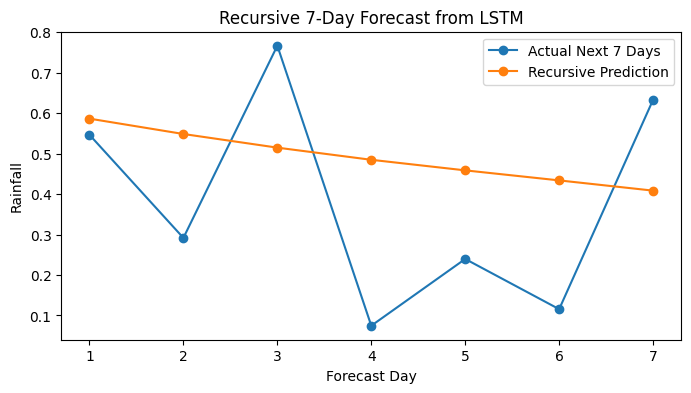

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ---------------------------
# 1. Generate Synthetic Data
# ---------------------------
np.random.seed(42)
days = 1000
rain = np.sin(np.linspace(0, 50, days)) + 0.3 * np.random.randn(days)
rain = rain.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
rain_scaled = scaler.fit_transform(rain)

# ---------------------------
# 2. Create Sequences (Sliding Window)
# ---------------------------
window_size = 30  # past 30 days -> predict next day only

X, y = [], []
for i in range(len(rain_scaled) - window_size):
    X.append(rain_scaled[i:i+window_size])
    y.append(rain_scaled[i+window_size])

X = np.array(X)
y = np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------------------------
# 3. Build LSTM Model (Single-Step)
# ---------------------------
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)  # predict next day only
])
model.compile(optimizer='adam', loss='mse')
model.summary()

# ---------------------------
# 4. Train Model
# ---------------------------
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# ---------------------------
# 5. Recursive Forecast Function
# ---------------------------
def recursive_forecast(model, input_sequence, n_steps=7):
    """
    input_sequence: last known window (shape: (window_size, 1))
    n_steps: number of days to forecast
    """
    forecast = []
    seq = input_sequence.copy()

    for _ in range(n_steps):
        pred = model.predict(seq.reshape(1, window_size, 1), verbose=0)
        forecast.append(pred[0, 0])
        # Slide window forward by 1, append prediction
        seq = np.vstack([seq[1:], pred])

    return np.array(forecast)

# ---------------------------
# 6. Test on First Test Sample
# ---------------------------
test_sample = X_test[0]
forecast_scaled = recursive_forecast(model, test_sample, n_steps=7)

# Inverse transform to original rainfall units
forecast_rescaled = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
actual_rescaled = scaler.inverse_transform(y_test[:7].reshape(-1, 1)).flatten()

# ---------------------------
# 7. Plot Result
# ---------------------------
plt.figure(figsize=(8, 4))
plt.plot(range(1, 8), actual_rescaled, 'o-', label="Actual Next 7 Days")
plt.plot(range(1, 8), forecast_rescaled, 'o-', label="Recursive Prediction")
plt.title("Recursive 7-Day Forecast from LSTM")
plt.xlabel("Forecast Day")
plt.ylabel("Rainfall")
plt.legend()
plt.show()